In [1]:
import time
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def KaliMatriks(A, B, n):
    """
    Brute-force matrix multiplication.
    Kembalikan (C, op_count) di mana op_count = # (mul + add).
    """
    C = [[0]*n for _ in range(n)]
    ops = 0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i][j] += A[i][k] * B[k][j]
                ops += 2    # satu multiplikasi + satu penjumlahan
    return C, ops

In [3]:
def add_matrix(A, B):
    """Return matrix sum tanpa hitung, untuk memudahkan Strassen."""
    n = len(A)
    C = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] + B[i][j]
    return C

def sub_matrix(A, B):
    """Return matrix difference tanpa hitung, untuk memudahkan Strassen."""
    n = len(A)
    C = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] - B[i][j]
    return C

def KaliMatriksStrassen(A, B, n):
    """
    Strassen matrix multiplication.
    Kembalikan (C, op_count) di mana op_count = # operasi add/sub/mul.
    """
    if n == 1:
        # scalar multiply
        return [[A[0][0]*B[0][0]]], 1

    mid = n//2
    # split A, B
    A11 = [row[:mid]      for row in A[:mid]]
    A12 = [row[mid:]      for row in A[:mid]]
    A21 = [row[:mid]      for row in A[mid:]]
    A22 = [row[mid:]      for row in A[mid:]]
    B11 = [row[:mid]      for row in B[:mid]]
    B12 = [row[mid:]      for row in B[:mid]]
    B21 = [row[:mid]      for row in B[mid:]]
    # B22 = [row[mid:]      for row in B[mid:]]
    B22 = [row[mid:]      for row in B[mid:]]

    total_ops = 0

    # M1 = Strassen(A12 - A22, B21 + B22)
    S1 = sub_matrix(A12, A22); total_ops += mid*mid
    S2 = add_matrix(B21, B22)
    M1, ops1 = KaliMatriksStrassen(S1, S2, mid); total_ops += ops1

    # M2 = Strassen(A11 + A22, B11 + B22)
    S1 = add_matrix(A11, A22); total_ops += mid*mid
    S2 = add_matrix(B11, B22); total_ops += mid*mid
    M2, ops2 = KaliMatriksStrassen(S1, S2, mid); total_ops += ops2

    # M3 = Strassen(A11 - A21, B11 + B12)
    S1 = sub_matrix(A11, A21); total_ops += mid*mid
    S2 = add_matrix(B11, B12); total_ops += mid*mid
    M3, ops3 = KaliMatriksStrassen(S1, S2, mid); total_ops += ops3

    # M4 = Strassen(A11 + A12, B22)
    S1 = add_matrix(A11, A12); total_ops += mid*mid
    M4, ops4 = KaliMatriksStrassen(S1, B22, mid); total_ops += ops4

    # M5 = Strassen(A11, B12 - B22)
    S2 = sub_matrix(B12, B22); total_ops += mid*mid
    M5, ops5 = KaliMatriksStrassen(A11, S2, mid); total_ops += ops5

    # M6 = Strassen(A22, B21 - B11)
    S2 = sub_matrix(B21, B11); total_ops += mid*mid
    M6, ops6 = KaliMatriksStrassen(A22, S2, mid); total_ops += ops6

    # M7 = Strassen(A21 + A22, B11)
    S1 = add_matrix(A21, A22); total_ops += mid*mid
    M7, ops7 = KaliMatriksStrassen(S1, B11, mid); total_ops += ops7

    # C11 = M1 + M2 - M4 + M6
    T1 = add_matrix(M1, M2); total_ops += mid*mid
    T2 = sub_matrix(T1, M4); total_ops += mid*mid
    C11 = add_matrix(T2, M6); total_ops += mid*mid

    # C12 = M4 + M5
    C12 = add_matrix(M4, M5); total_ops += mid*mid

    # C21 = M6 + M7
    C21 = add_matrix(M6, M7); total_ops += mid*mid

    # C22 = M2 - M3 + M5 - M7
    T1 = sub_matrix(M2, M3); total_ops += mid*mid
    T2 = add_matrix(T1, M5); total_ops += mid*mid
    C22 = sub_matrix(T2, M7); total_ops += mid*mid

    # gabungkan kembali
    C = [[0]*n for _ in range(n)]
    for i in range(mid):
        for j in range(mid):
            C[i][j]           = C11[i][j]
            C[i][j+mid]       = C12[i][j]
            C[i+mid][j]       = C21[i][j]
            C[i+mid][j+mid]   = C22[i][j]

    return C, total_ops

   n    time_bf     ops_bf     time_st     ops_st
 256   3.139224   33554432   23.426361   38060636
 512  26.462824  268435456  150.722869  267538564
1024 284.647667 2147483648 1196.753999 1877226396


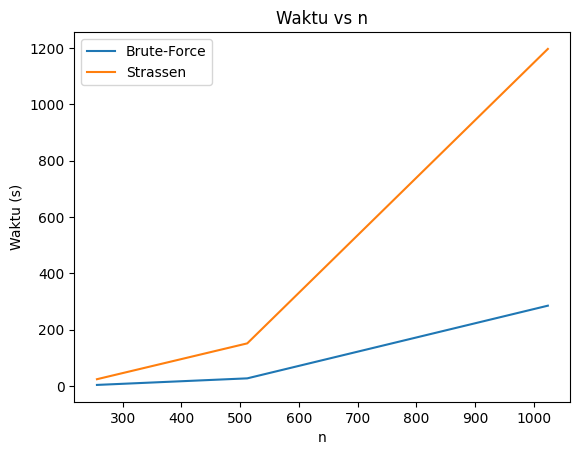

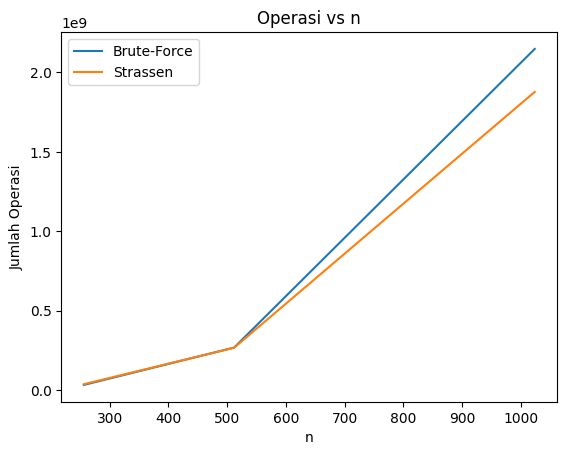

In [4]:
# ———————————————————————————————
# Pengujian sekaligus waktu & kompleksitas
# ———————————————————————————————
# n_values = [2, 4, 8, 16, 32]
n_values = [256, 512, 1024]

records = []

for n in n_values:
    # generate matriks random
    A = [[random.randint(0,999999) for _ in range(n)] for _ in range(n)]
    B = [[random.randint(0,999999) for _ in range(n)] for _ in range(n)]

    # brute-force
    t0 = time.perf_counter()
    _, bf_ops = KaliMatriks(A, B, n)
    t_bf = time.perf_counter() - t0

    # strassen
    t0 = time.perf_counter()
    _, st_ops = KaliMatriksStrassen(A, B, n)
    t_st = time.perf_counter() - t0

    records.append({
        'n':        n,
        'time_bf':  t_bf,
        'ops_bf':   bf_ops,
        'time_st':  t_st,
        'ops_st':   st_ops
    })

df = pd.DataFrame(records)
print(df.to_string(index=False))

# Plot
plt.figure()
plt.plot(df['n'], df['time_bf'], label='Brute-Force')
plt.plot(df['n'], df['time_st'], label='Strassen')
plt.xlabel('n')
plt.ylabel('Waktu (s)')
plt.legend()
plt.title('Waktu vs n')

plt.figure()
plt.plot(df['n'], df['ops_bf'], label='Brute-Force')
plt.plot(df['n'], df['ops_st'], label='Strassen')
plt.xlabel('n')
plt.ylabel('Jumlah Operasi')
plt.legend()
plt.title('Operasi vs n')

plt.show()